In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy as sp
import json
import os
import math

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

#from mpl_toolkits.basemap import Basemap, cm
from matplotlib.path import Path

from datetime import datetime
from dateutil import tz
import time
import datetime
import calendar


from stravalib.client import Client
from stravalib import unithelper

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


In [2]:
m_to_yd = 1.09361
json_data=open('{0}/strava_credentials.json'.format(os.getenv("HOME"))).read()
credentials = json.loads(json_data)
client = Client(access_token=credentials['AccessToken'])

In [3]:
def rolling_haversine(df):
    radius = 6371 # km
    
    d_ll = df.rolling(2).apply(lambda x: math.radians(x[1]-x[0]))
    ll = df.lat.rolling(2).apply(lambda x: math.cos(math.radians(x[0])) * math.cos(math.radians(x[1])))
    
    a = d_ll.lat.apply(lambda x: math.sin(x/2) * math.sin(x/2)) + \
        ll * d_ll.lon.apply(lambda x: math.sin(x/2) * math.sin(x/2))
    c = 2 * a.apply(lambda x: math.atan2(math.sqrt(x), math.sqrt(1-x)) )
    
    d = radius * c
    
    return d


In [85]:
def plot_courses(courses):
    fig = plt.figure(facecolor = '0.05')
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_aspect('equal')
    ax.set_axis_off()
    fig.add_axes(ax)
    for id in courses.id.unique().tolist():
        plt.plot(courses[courses.id==id].lon, courses[courses.id==id].lat, color = 'deepskyblue', lw = 0.5, alpha = 0.8)

In [4]:
activities = client.get_activities()

my_swims = pd.DataFrame([{'name':activity.name, 
                          'id': activity.id, 
                          'stroke_count': 2 * activity.average_cadence if activity.average_cadence is not None else None,
                          'average_speed':float(unithelper.meters_per_second(activity.average_speed)),
                          'elapsed_time':unithelper.timedelta_to_seconds(activity.elapsed_time), 'start_date': activity.start_date,
                          'distance':float(unithelper.meters(activity.distance)) * m_to_yd} 
                         for activity in activities if activity.type=='Swim' and activity.map.summary_polyline is not None])
my_swims = my_swims.set_index('start_date')
my_swims.index = pd.DatetimeIndex(my_swims.index)
my_swims.index = my_swims.index.tz_convert('US/Pacific')
my_swims['month'] = my_swims.index.month
my_swims['month'] = my_swims['month'].apply(lambda x: calendar.month_abbr[x])
my_swims['ds_week_ending'] = my_swims.index.to_period('W').end_time
my_swims.elapsed_time = my_swims.elapsed_time.apply(lambda elapsed: pd.Timedelta(int(elapsed), unit='s'))

No handlers could be found for logger "stravalib.model.Activity"


In [20]:
courses = pd.DataFrame()
courses_dict = {}
for activity in activities:
    if activity.type=='Swim' and activity.map.summary_polyline is not None:
        course = pd.DataFrame(
            client.get_activity_streams(activity.id, types=['latlng'], series_type='time')['latlng'].data,
            index=None, columns=['lat', 'lon']) 
        course['id'] = activity.id
        courses = courses.append(course)
        courses_dict[activity.id] = course


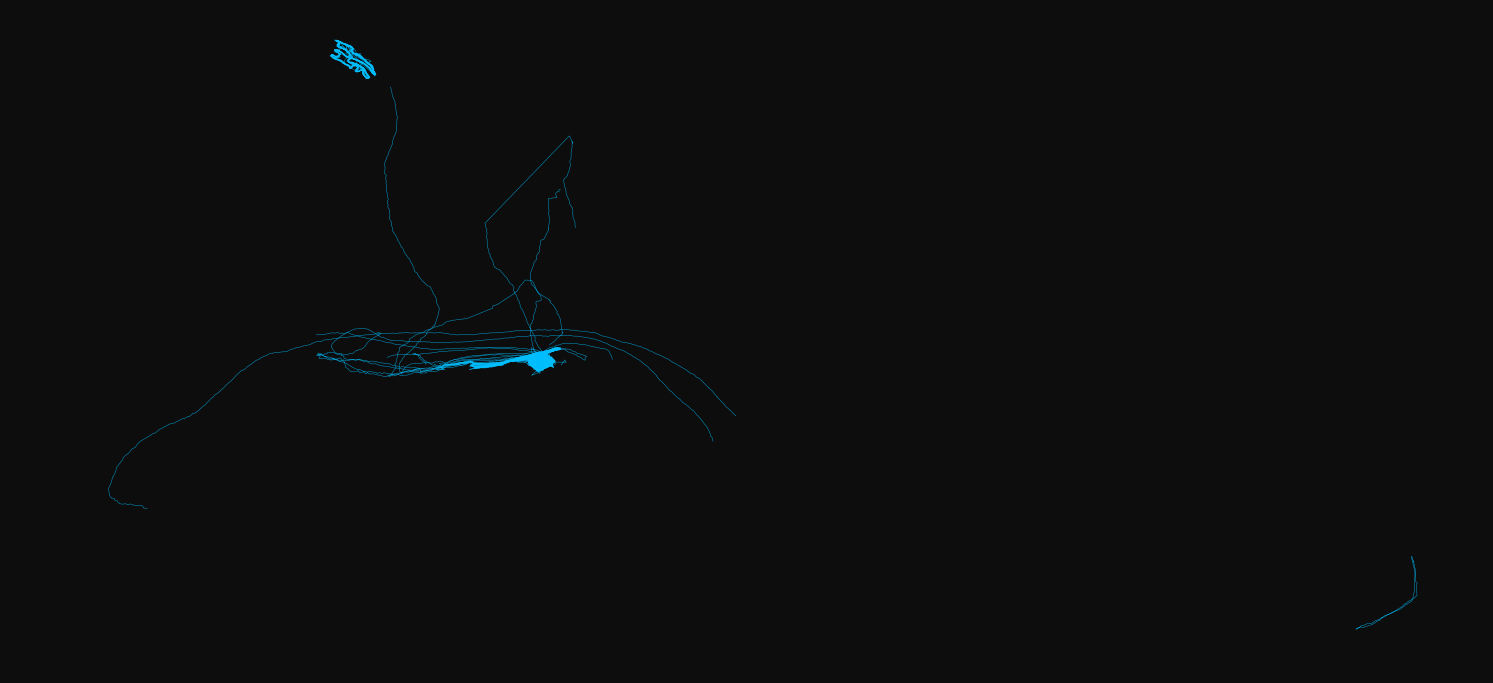

In [86]:
# Bay Area
# 37.8272° N, 122.2913° W
courses['bay_area'] = courses.apply(lambda x: math.floor(x['lat'])==37 and math.floor(abs(x['lon']))==122, axis=1)
plot_courses(courses[courses['bay_area']])

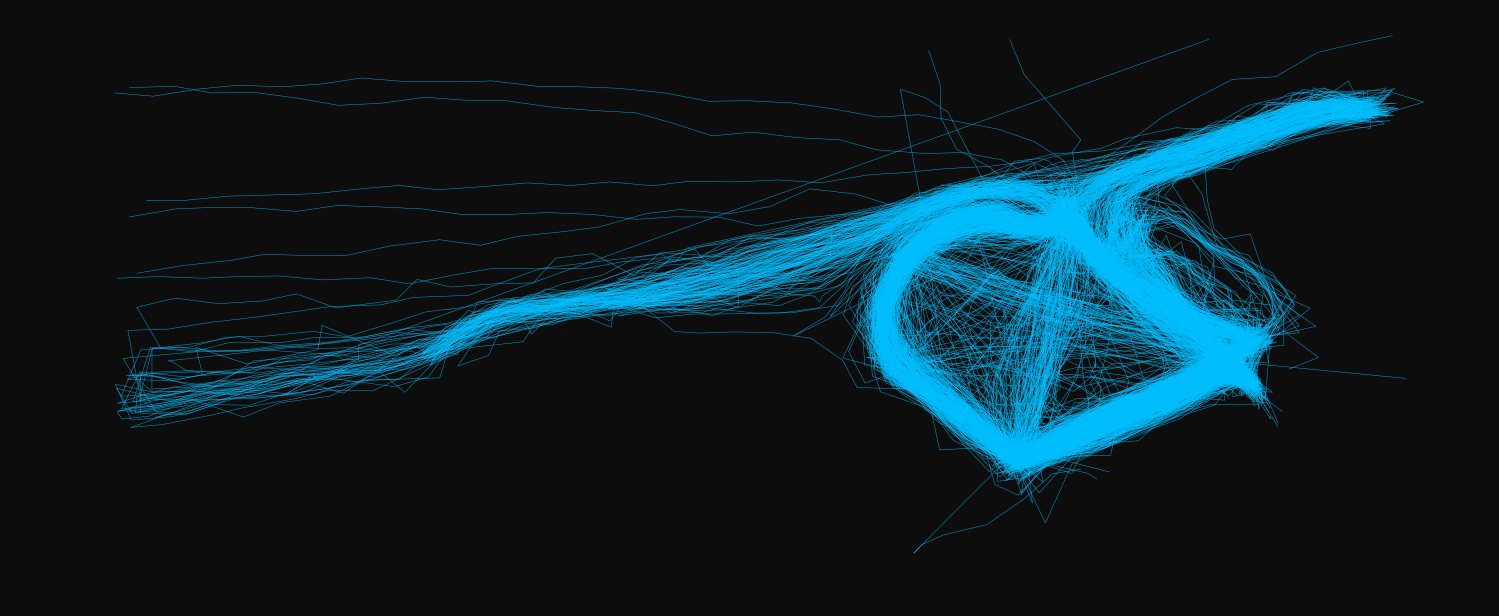

In [87]:
# Cove
# 37°48'31.1"N 122°25'27.4"W
# 37.808641, -122.424288
courses['ap_cove'] = courses.apply(lambda x: (x['lat'] <= 37.813 and x['lat'] >= 37.80) and
                                   (x['lon'] <= -122.419 and x['lon'] >= -122.437), axis=1)
plot_courses(courses[courses['ap_cove']])

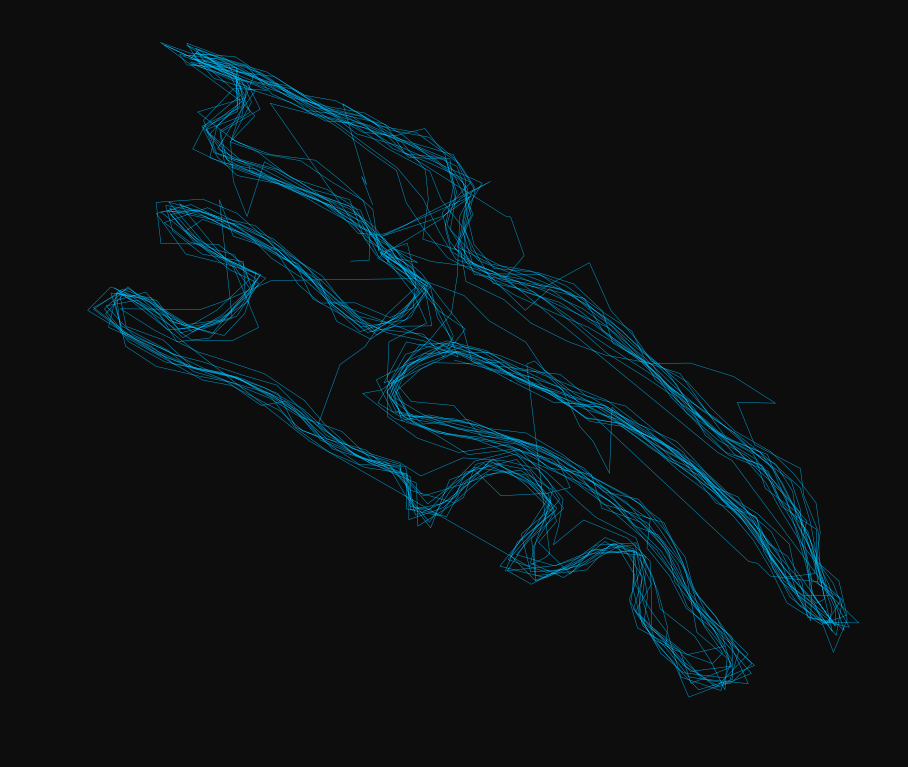

In [88]:
# Lagoon
# 37°52'41.7"N 122°28'04.6"W
# 37.878259, -122.467952
courses['lagoon'] = courses.apply(lambda x: (x['lat'] <= 37.89 and x['lat'] >= 37.872) and
                                   (x['lon'] <= -122.44 and x['lon'] >= -122.49), axis=1)
plot_courses(courses[courses['lagoon']])

* by duration
* look at specifics
* stroke rate?

In [63]:
exclude_ids = [766916495, 822123587, 821042032, 554752952]

In [111]:
my_swims[my_swims.id.apply(lambda id: id  in exclude_ids)]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,approx_distance,delta,ratio
start_date,,,,,,,,,,,
2017-01-05 07:16:01-08:00,0.471,1495.074231,00:48:25,822123587,Another GPS fuckup..,74.8,Jan,2017-01-08,1701.386673,206.312442,1.137995
2017-01-04 07:11:31-08:00,0.635,1798.988450,00:43:10,821042032,GPS mishap,73.8,Jan,2017-01-08,1904.247618,105.259168,1.058510
2016-11-05 06:46:04-07:00,0.797,7308.704991,04:20:02,766916495,Helping Private Ryan,73.0,Nov,2016-11-06,10218.077523,2909.372532,1.398069
2016-04-23 14:41:49-07:00,1.117,1551.067063,00:21:10,554752952,Short Sunny Swim Fail,74.2,Apr,2016-04-24,1422.489362,-128.577701,0.917104


In [58]:
true_distance = {}
for swim_id in courses_dict.keys():
    true_distance[swim_id] = 1000 * rolling_haversine(courses_dict[swim_id]).sum() * m_to_yd
my_swims['approx_distance'] = my_swims.id.apply(lambda x: np.nan if x not in true_distance.keys() else true_distance[x])
my_swims['delta'] = my_swims['approx_distance'] - my_swims['distance']
my_swims['ratio'] = my_swims['approx_distance'] / my_swims['distance']

In [89]:
all_dist = pd.Series()
for swim_id in courses_dict.keys():
    if swim_id not in exclude_ids:
        all_dist = all_dist.append(rolling_haversine(courses_dict[swim_id]) * m_to_yd)

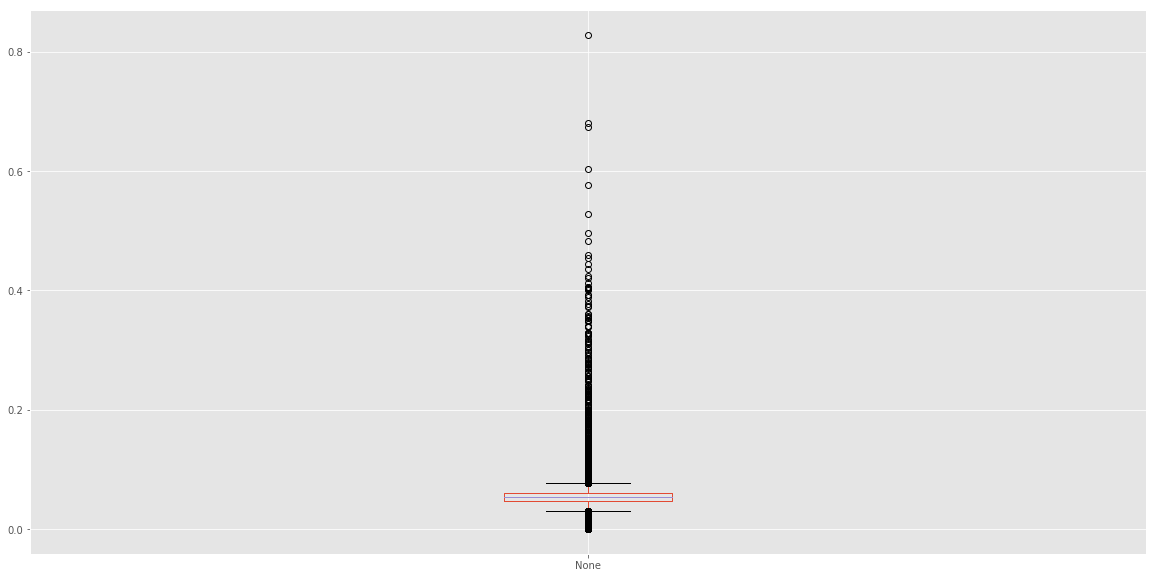

In [90]:
all_dist.plot(kind='box')

In [91]:
my_swims['delta'].sum()

3035.717338739564

Text(0.5,0,u'% Difference')

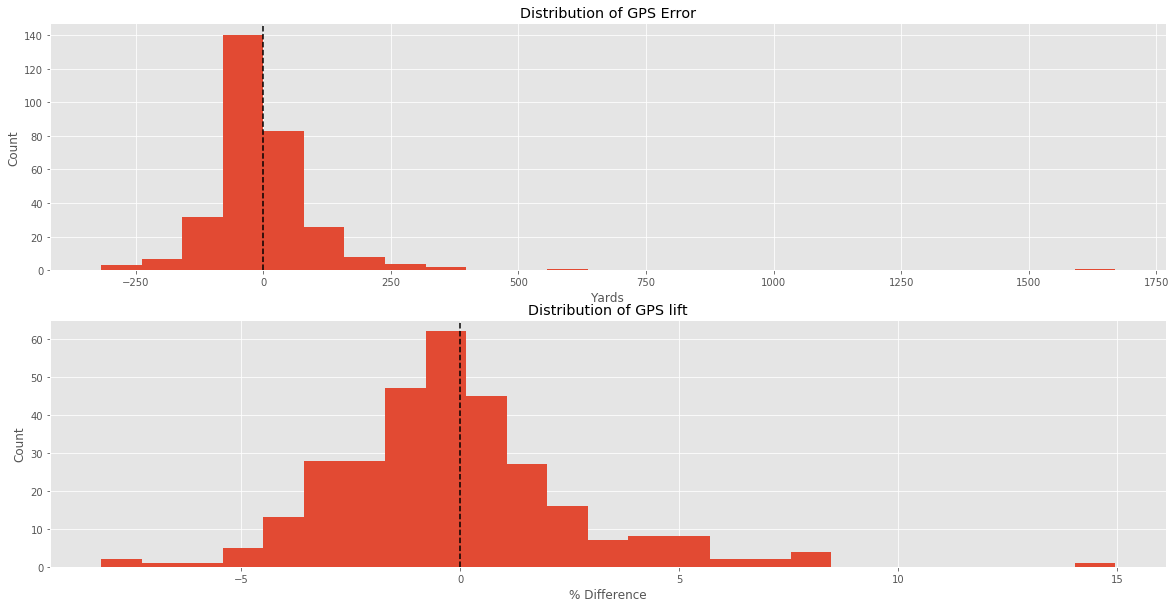

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=1)
my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].delta.hist(ax=axes[0], bins=25)
axes[0].axvline(0, color='k', linestyle='--')
axes[0].set_title('Distribution of GPS Error')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Yards')


(100*my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].ratio-100).hist(ax=axes[1], bins=25)
axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_title('Distribution of GPS lift')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('% Difference')


In [94]:
my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)][
    my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].delta==my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].delta.max()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,approx_distance,delta,ratio
start_date,,,,,,,,,,,
2017-07-21 21:16:22-07:00,0.853,27025.399681,29837.0,1095839772,9 to 5: Dusk till Dawn.,64.0,Jul,2017-07-23,28695.349089,1669.949408,1.061792


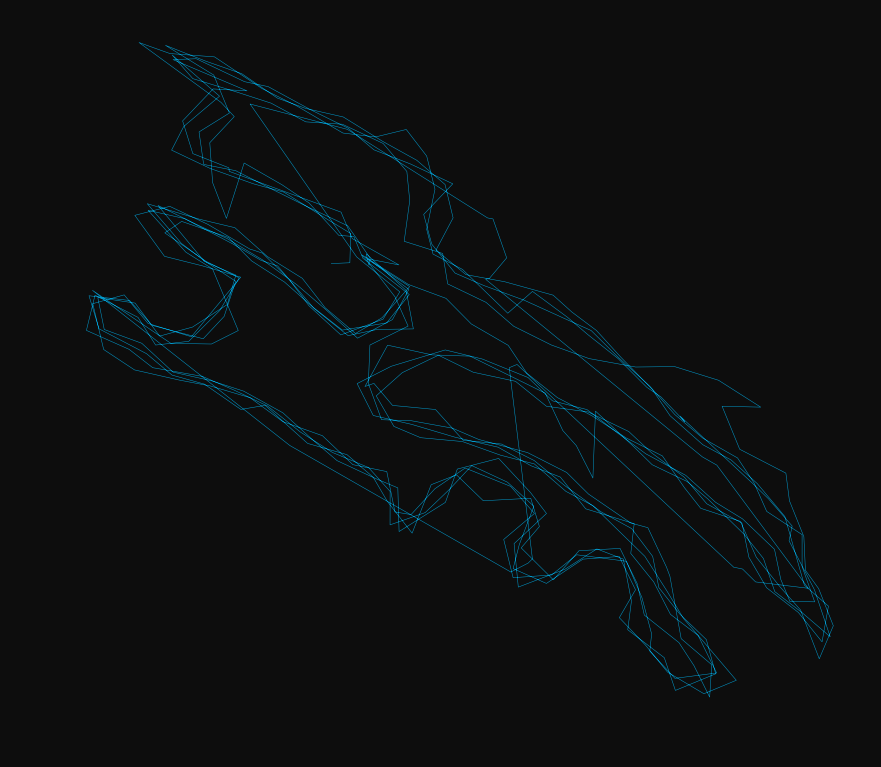

In [95]:
plot_courses(courses_dict[1095839772])

In [96]:
my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)][
    my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].delta==my_swims[my_swims.id.apply(lambda id: id not in exclude_ids)].delta.min()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,approx_distance,delta,ratio
start_date,,,,,,,,,,,
2017-07-01 06:25:19-07:00,0.85,10462.129426,11261.0,1062693771,My leg hates me.,73.4,Jul,2017-07-02,10143.977448,-318.151978,0.96959


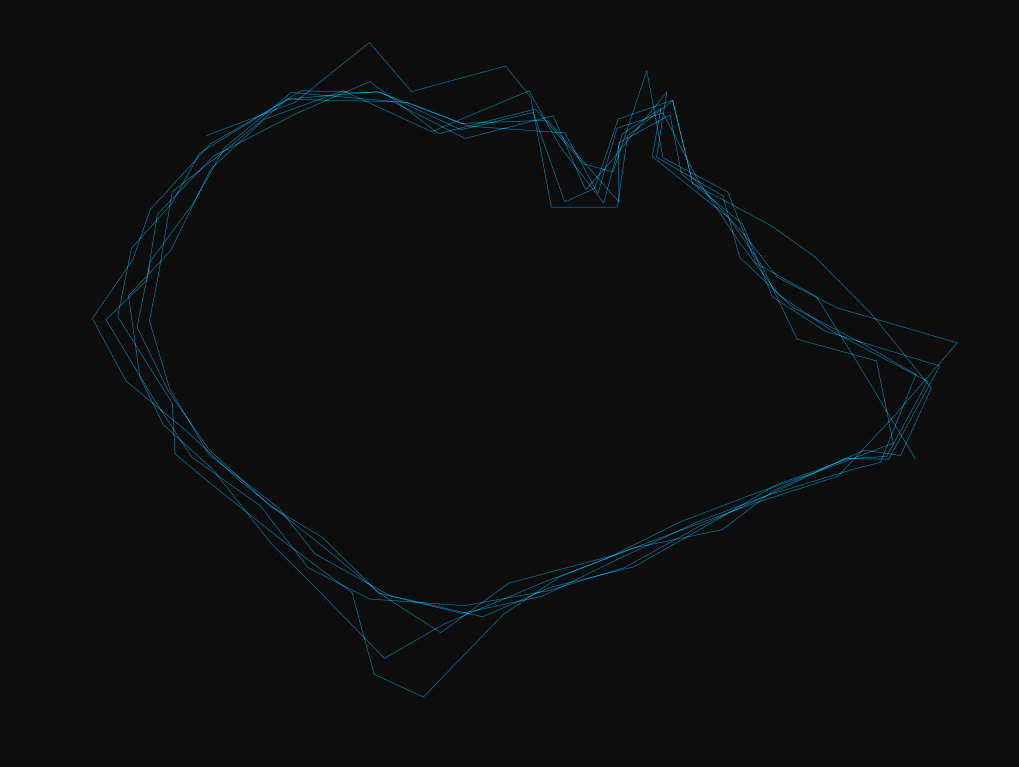

In [97]:
plot_courses(courses_dict[1062693771])

In [30]:
my_swims[my_swims.ratio==my_swims.ratio.max()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-04 17:02:34-07:00,0.948,1610.778169,1553.0,536045820,Afternoon Swim,68.6,Apr,2016-04-10,open water,1744.550292,133.772123,1.083048


In [32]:
my_swims[my_swims.ratio==my_swims.ratio.min()]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-23 14:41:49-07:00,1.117,1551.067063,1270.0,554752952,Short Sunny Swim Fail,74.2,Apr,2016-04-24,open water,1422.489362,-128.577701,0.917104


In [33]:
my_swims[my_swims.name.apply(lambda x: 'Fail' in x)]

,average_speed,distance,elapsed_time,id,name,stroke_count,month,ds_week_ending,is_pool,approx_distance,delta,ratio
start_date,,,,,,,,,,,,
2016-04-23 14:41:49-07:00,1.117,1551.067063,1270.0,554752952,Short Sunny Swim Fail,74.2,Apr,2016-04-24,open water,1422.489362,-128.577701,0.917104
